In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
from heapq import heappop, heappush

In [2]:
'''Grid'''
class Map:

    # 
    def __init__(self):
        '''
        Default constructor
        '''

        self.width = 0
        self.height = 0
        self.cells = []
    

    def SetGridCells(self, width, height, gridCells):
        '''
        Initialization of map by list of cells.
        '''
        self.width = width
        self.height = height
        self.cells = gridCells


    def inBounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= i < self.width) and (0 <= j < self.height)
    

    def Traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self.cells[j][i]


    def GetNeighbors(self, i, j):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        '''   
        neighbors = [[i, j]]
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]

        for d in delta:
            if self.inBounds(i + d[0], j + d[1]) and self.Traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
        return neighbors

In [3]:
def read_map_from_movingai_file(path):
    map_file = open(path)
    count = 0
    name = map_file.readline()
    height = int(map_file.readline().split()[1])
    width = int(map_file.readline().split()[1])
    type_ = map_file.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    
    i = 0
    j = 0

    for l in map_file:
        j = 0
        for c in l:
            if c == '.':
                cells[i][j] = 0
            elif c == 'T' or c == '@':
                cells[i][j] = 1
            else:
                continue
            
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break
    
    return (width, height, cells)

def read_tasks_from_movingai_file(path):
    tasks = []
    task_file = open(path)
    for l in task_file:
        new_task = l.split()[4:]
        if len(new_task) != 0:
            tasks.append(list(map(float,new_task)))
    #возвращает числа: координаты начала и конца, длину пути
    return np.array(tasks, int)

In [4]:
class HighNode:
    '''
    HighNode class represents a high-level search node

    - vertexCons: vertex constraints of the node
    - edgeCons: edge constraints of the node
    - sol: solution of the node
    - g: cost of the solution of the node 
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    '''

    def __init__(self, vertexCons={}, edgeCons={}, sol={}, g=0, h=0, F=None, parent=None, k=0):
        self.vertexCons = vertexCons
        self.edgeCons = edgeCons
        self.sol = sol
        self.g = g
        self.h = h
        self.k = k
        if F is None:
            self.F = g + h
        else:
            self.F = F        
        self.parent = parent
    
    
    def __eq__(self, other):
        return (self.vertexCons == other.vertexCons) and (self.edgeCons == other.edgeCons) and \
               (self.sol == other.sol)
    
    def __lt__(self, other):
        return self.F < other.F or ((self.F == other.F) and (self.h < other.h)) \
        or ((self.F == other.F) and (self.h == other.h))

In [5]:
class LowNode:
    '''
    LowNode class represents a low-level search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node 
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 
    '''

    def __init__(self, coord, g=0, h=0, F=None, parent=None):
        self.i = coord[0]
        self.j = coord[1]
        self.g = g
        self.h = h
        if F is None:
            self.F = g + h
        else:
            self.F = F        
        self.parent = parent
    
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j) and (self.g == other.g)
    
    def __lt__(self, other):
        return self.F < other.F or ((self.F == other.F) and (self.h < other.h)) \
        or ((self.F == other.F) and (self.h == other.h))

In [6]:
class MetaAgent:
    '''
    MetaAgent class represents a meta-agent
    
    - agents: set of agents of the meta-agent
    '''
    
    def __init__(self, agents):
        self.agents = agents
        
    def __eq__(self, other):
        return self.agents == other.agents
    
    def __repr__(self):   
        return 'Meta-agent consists of №{} agents'.format(" ".join([str(item) for item in self.agents]))
    
    def __hash__(self):
        return hash(repr(self))

In [7]:
class OpenHigh:
    
    def __init__(self):
        self.heap = []
    
    
    def __iter__(self):
        return iter(self.heap)
    
    
    def AddNode(self, node : HighNode):
        heappush(self.heap, node)

        
    def GetBestNode(self):        
        best = heappop(self.heap)
        
        return best

In [8]:
class OpenLow:
    
    def __init__(self):
        self.heap = []
        self.elements = {}
    
    def __iter__(self):
        return iter(self.elements.values())
    
    def __len__(self):
        return len(self.elements)

    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        return True

    def AddNode(self, node : LowNode, *args):
        if self.elements.get((node.i, node.j, node.g)) is None or node < self.elements[(node.i, node.j, node.g)]:
            self.elements[(node.i, node.j, node.g)] = node
            heappush(self.heap, node)
        return

    def GetBestNode(self, CLOSED, *args):
        best = heappop(self.heap)    
        while CLOSED.WasExpanded(best):
            best = heappop(self.heap)
        del self.elements[(best.i, best.j, best.g)]
        return best

In [9]:
class ClosedLow:
    
    def __init__(self):
        self.elements = {}


    def __iter__(self):
        return iter(self.elements.values())
    

    def __len__(self):
        return len(self.elements)


    def AddNode(self, node : LowNode):
        self.elements[(node.i, node.j, node.g)] = node


    def WasExpanded(self, node : LowNode):
        return not self.elements.get((node.i, node.j, node.g)) is None

In [10]:
def ManhattanDistance(i1, j1, i2, j2):
    return abs(i1 - i2) + abs(j1 - j2)

In [11]:
def MakePath(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [12]:
class AstarTimesteps:
    def __init__(self, gridMap, iStart, jStart, iGoal, jGoal, vertexCons, edgeCons):
        self.vertexCons = vertexCons
        self.edgeCons = edgeCons
        self.CLOSED = ClosedLow()
        self.gridMap = gridMap
        self.iStart = iStart
        self.jStart = jStart
        self.iGoal = iGoal
        self.jGoal = jGoal
        self.OPEN = OpenLow()
        self.path = []
        
    def CheckMove(self, i1, j1, i2, j2, t):
        for obs in self.vertexCons:
            if obs[1] == t + 1 and obs[0] == (i2, j2):
                return False
        
        for obs in self.edgeCons:
            if obs[2] == t + 1 and obs[0] == (i1, j1) and obs[1] == (i2, j2):
                return False
                
        return True
    
    def FindPath(self):
        startNode = LowNode(coord=(self.iStart, self.jStart))
        self.OPEN.AddNode(startNode)
    
        while not self.OPEN.isEmpty():
            s = self.OPEN.GetBestNode(self.CLOSED) 
            self.CLOSED.AddNode(s)       
            if s.i == self.iGoal and s.j == self.jGoal:
                return (True, s, self.OPEN, self.CLOSED)
            for nbr in self.gridMap.GetNeighbors(s.i, s.j):
                if self.CheckMove(s.i, s.j, nbr[0], nbr[1], s.g) and \
                not self.CLOSED.WasExpanded(LowNode(coord=nbr, g=s.g + 1)):
                    nbrNode = LowNode(coord=nbr, g=s.g + 1, h=ManhattanDistance(nbr[0], nbr[1], self.iGoal, self.jGoal), \
                                      parent=s)
                    self.OPEN.AddNode(nbrNode)
        return (False, None, self.OPEN, self.CLOSED)

In [13]:
def CBS(gridMap, Starts, Goals, subset=[], vertexCons=[], edgeCons=[]): # subset, vertex/edge- Cons - нужны только при вызове CBS в качестве нижнего уровня MACBS
    tic = time.perf_counter() # начало работы функции
    
    gen = 0
    exp = 0
    
    root = HighNode(vertexCons={}, edgeCons={}, sol={}, k=gen)
    OPEN = OpenHigh()
    agents = list(range(len(Starts)))
    if len(subset) > 0:
        agents = subset.copy()
    
    for vc in vertexCons:
        # перебираем агентов из подмножества
        for a in vc[0]:
            if a in root.vertexCons:
                root.vertexCons[a].append((vc[1], vc[2]))
            else:
                root.vertexCons[a] = [(vc[1], vc[2])]
                
    for ec in edgeCons:
        # перебираем агентов из подмножества
        for a in ec[0]:
            if a in root.edgeCons:
                root.edgeCons[a].append((ec[1], ec[2], ec[3]))
            else:
                root.edgeCons[a] = [(ec[1], ec[2], ec[3])]
                
    for a in agents:
        VC = []
        EC = []
        if a in root.vertexCons:
            VC = root.vertexCons[a]
        if a in root.edgeCons:
            EC = root.edgeCons[a]
            
        planner = AstarTimesteps(gridMap, Starts[a][0], Starts[a][1], Goals[a][0], Goals[a][1], VC, EC)
        res = planner.FindPath()
        if res[0]:
            path = MakePath(res[1])
            root.sol[a], _ = path
        else:
            return (False, None, gen, exp)
    
    root.g = sum([len(path) for path in root.sol.values()])
    OPEN.AddNode(root)
    gen += 1
    
    toc = time.perf_counter()
    
    while toc - tic < 60:
        s = OPEN.GetBestNode()
        exp += 1
        
        newVertexCons = []
        newEdgeCons = []
        
        for i, a in enumerate(agents):
            for b in agents[i + 1 :]:
                for step in range(min(len(s.sol[a]), len(s.sol[b]))):
                    if s.sol[a][step].i == s.sol[b][step].i and s.sol[a][step].j == s.sol[b][step].j:
                        newVertexCons.append((a, b, (s.sol[a][step].i, s.sol[a][step].j), step))
                    if step + 1 < min(len(s.sol[a]), len(s.sol[b])) and \
                       s.sol[a][step].i == s.sol[b][step + 1].i and s.sol[a][step].j == s.sol[b][step + 1].j and \
                       s.sol[a][step + 1].i == s.sol[b][step].i and s.sol[a][step + 1].i == s.sol[b][step].i:
                        newEdgeCons.append((
                            a,
                            b,
                            (s.sol[a][step].i, s.sol[a][step].j),
                            (s.sol[a][step + 1].i, s.sol[a][step + 1].j),
                            step,
                        ))
                        
        if len(newVertexCons) == 0 and len(newEdgeCons) == 0:
            return (True, s, gen, exp)
        
        # Сейчас сначала разрешаются вершинные конфликты, потом реберные
        if len(newVertexCons) > 0:
            a, b, (i, j), t = newVertexCons[0]
            
            # Разбиваем CT на ноды A и B, разрешая вершинный конфликт 
            
            tmp = s.vertexCons.copy()
            if a in tmp:
                tmp[a].append(((i, j), t))   
            else:
                tmp[a] = [((i, j), t)]
            
            A = HighNode(
                vertexCons=tmp,
                edgeCons=s.edgeCons.copy(),
                sol=s.sol.copy(),
                parent=s,
                k=gen,
            )
            
            ec = []
            if a in A.edgeCons:
                ec = A.edgeCons[a]
            
            planner = AstarTimesteps(gridMap, Starts[a][0], Starts[a][1], Goals[a][0], Goals[a][1], A.vertexCons[a], ec)
            res = planner.FindPath()
            if res[0]:
                path = MakePath(res[1])
                A.sol[a], _ = path
                A.g = sum([len(path) for path in A.sol.values()]) # SIC, можно использовать другой cost; добавить подсчет h, F
                OPEN.AddNode(A)
                gen += 1
                
            tmp = s.vertexCons.copy()
            if b in tmp:
                tmp[b].append(((i, j), t))   
            else:
                tmp[b] = [((i, j), t)]
                
            B = HighNode(
                vertexCons=tmp,
                edgeCons=s.edgeCons.copy(),
                sol=s.sol.copy(),
                parent=s,
                k=gen,
            )
            
            ec = []
            if b in B.edgeCons:
                ec = B.edgeCons[b]
            
            planner = AstarTimesteps(gridMap, Starts[b][0], Starts[b][1], Goals[b][0], Goals[b][1], B.vertexCons[b], ec)
            res = planner.FindPath()
            if res[0]:
                path = MakePath(res[1])
                B.sol[b], _ = path
                B.g = sum([len(path) for path in B.sol.values()]) # SIC, можно использовать другой cost; добавить подсчет h, F
                OPEN.AddNode(B)
                gen += 1
                
        elif len(newEdgeCons) > 0:
            a, b, (i1, j1), (i2, j2), t = newEdgeCons[0]
            
            # Разбиваем CT на ноды A и B, разрешая реберный конфликт 
            
            tmp = s.edgeCons.copy()
            if a in tmp:
                tmp[a].append(((i1, j1), (i2, j2), t))   
            else:
                tmp[a] = [((i1, j1), (i2, j2), t)]
            
            A = HighNode(
                vertexCons=s.vertexCons.copy(),
                edgeCons=tmp,
                sol=s.sol.copy(),
                parent=s,
                k=gen,
            )
            
            vc = []
            if a in A.vertexCons:
                vc = A.vertexCons[a]
            
            planner = AstarTimesteps(gridMap, Starts[a][0], Starts[a][1], Goals[a][0], Goals[a][1], vc, A.edgeCons[a])
            res = planner.FindPath()
            if res[0]:
                path = MakePath(res[1])
                A.sol[a], _ = path
                A.g = sum([len(path) for path in A.sol.values()]) # SIC, можно использовать другой cost; добавить подсчет h, F
                OPEN.AddNode(A)
                gen += 1
                
            tmp = s.edgeCons.copy()
            if b in tmp:
                tmp[b].append(((i1, j1), (i2, j2), t))   
            else:
                tmp[b] = [((i1, j1), (i2, j2), t)]
            
            B = HighNode(
                vertexCons=s.vertexCons.copy(),
                edgeCons=tmp,
                sol=s.sol.copy(),
                parent=s,
                k=gen,
            )
            
            vc = []
            if b in B.vertexCons:
                vc = B.vertexCons[b]
            
            planner = AstarTimesteps(gridMap, Starts[b][0], Starts[b][1], Goals[b][0], Goals[b][1], vc, B.edgeCons[b])
            res = planner.FindPath()
            if res[0]:
                path = MakePath(res[1])
                B.sol[b], _ = path
                B.g = sum([len(path) for path in B.sol.values()]) # SIC, можно использовать другой cost; добавить подсчет h, F
                OPEN.AddNode(B)
                gen += 1
                
        toc = time.perf_counter()
    
    return (False, None, gen, exp)

Final cost 243,
Euclidean cost 187


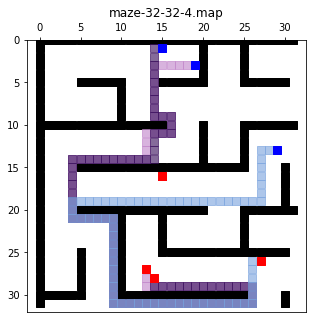

In [19]:
# Один тест CBS

map_file = 'tests/maze-32-32-4.map'
scen_file = 'tests/tests-maze/maze-32-32-4-even-1.scen'

w, h, cells = read_map_from_movingai_file(map_file)
tasks = read_tasks_from_movingai_file(scen_file)

task_map = Map()
task_map.SetGridCells(w, h, cells)

num = 4

Starts = [(item[0], item[1]) for item in tasks[2:num+2]]
Goals = [(item[2], item[3]) for item in tasks[2:num+2]]

result = CBS(task_map, Starts, Goals)

if result[0]:
    print(f'Final cost {result[1].g},\nEuclidean cost {sum([tasks[i][-1] for i in range(num)])}')
    
    obs_x = []
    obs_y = []

    for y, cell_y in enumerate(task_map.cells):
        for x, cell_x in enumerate(cell_y):
            if cell_x == 1:
                obs_x.append(x)
                obs_y.append(y)
            
    x = np.array(obs_x)
    y = np.array(obs_y)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.set_ylim(task_map.height, 0)
    ax.xaxis.set_ticks_position('top')

    ax.scatter(x, y, c='black', marker='s', s=50)
    ax.set_facecolor('white')
    ax.set_title(map_file)

    color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) + ''.join(['A', '0'])
             for i in range(num)]

    for a in result[1].sol:
        path = result[1].sol[a]
        x = []
        y = []
        for node in path:
            x.append(node.i)
            y.append(node.j)
        ax.scatter(x[1:-1], y[1:-1], c=color[a], marker='s', s=50)
        ax.scatter(x[:1], y[:1], c='blue', marker='s', s=50)
        ax.scatter(x[-1:], y[-1:], c='red', marker='s', s=50)

    plt.show()

In [20]:
def MAConflict(node: HighNode, CM, a : MetaAgent, b : MetaAgent):
    vertexConflicts = []
    edgeConflicts = []
    
    for x in a.agents:
        for y in b.agents:
            for step in range(min(len(node.sol[a][x]), len(node.sol[b][y]))):
                if node.sol[a][x][step].i == node.sol[b][y][step].i and node.sol[a][x][step].j == node.sol[b][y][step].j:
                    CM[x][y] += 1
                    CM[y][x] += 1
                    vc = (a, b, (node.sol[a][x][step].i, node.sol[a][x][step].j), step)
                    if vc not in vertexConflicts:
                        vertexConflicts.append(vc)
                if step + 1 < min(len(node.sol[a][x]), len(node.sol[b][y])) and \
                   node.sol[a][x][step].i == node.sol[b][y][step + 1].i and node.sol[a][x][step].j == node.sol[b][y][step + 1].j \
                   and node.sol[a][x][step + 1].i == node.sol[b][y][step].i and node.sol[a][x][step + 1].i == node.sol[b][y][step].i:
                    CM[x][y] += 1
                    CM[y][x] += 1
                    ec = (
                        a,
                        b,
                        (node.sol[a][x][step].i, node.sol[a][x][step].j),
                        (node.sol[a][x][step + 1].i, node.sol[a][x][step + 1].j),
                        step,
                    )
                    if ec not in edgeConflicts:
                        edgeConflicts.append(ec)
                        
    return CM, vertexConflicts, edgeConflicts

In [21]:
def CheckMerge(CM, Border, a: MetaAgent, b : MetaAgent):
    cnt = 0
    
    for x in a.agents:
        for y in b.agents:
            cnt += CM[x][y]
            
    return cnt > Border

In [22]:
def Merge(a : MetaAgent, b : MetaAgent, node : HighNode):
    newMetaAgent = MetaAgent(a.agents + b.agents)
    newVertexCons = {}
    newEdgeCons = {}
        
    # удаляем vertex internal constraints
    for ma in node.vertexCons:
        if ma == a or ma == b:
            newVC = []
            for vc in node.vertexCons[ma]:
                if vc[-1] != a and vc[-1] != b:
                    # vertex constraint теперь выглядит так: (subset, v, t, meta-agent)
                    new_vc = (ma.agents, vc[2], vc[3], vc[4])
                    newVC.append(new_vc)
            newVertexCons[ma] = newVC
        else:
            newVertexCons[ma] = node.vertexCons[ma]
    
    # удаляем edge internal constraints
    for ma in node.edgeCons:
        if ma == a or ma == b:
            newEC = []
            for ec in node.edgeCons[ma]:
                if ec[-1] != a and ec[-1] != b:
                    # edge constraint теперь выглядит так: (subset, v1, v2, t, meta-agent)
                    new_ec = (ma.agents, ec[1], ec[2], ec[3], ec[4])
                    newEC.append(new_ec)
            newEdgeCons[ma] = newEC
        else:
            newEdgeCons[ma] = node.edgeCons[ma]
            
    
    return newMetaAgent, newVertexCons, newEdgeCons

In [33]:
def MACBS(gridMap, Starts, Goals, Border, isMR=False):
    tic = time.perf_counter() # начало работы функции
    
    gen = 0
    exp = 0
    
    root = HighNode(vertexCons={}, edgeCons={}, sol={}, k=gen)
    OPEN = OpenHigh()
    agents = [MetaAgent([i]) for i in range(len(Starts))]
    CM = [[0] * len(agents)] * len(agents) # матрица конфликтов
    
    for a in range(len(agents)):
        planner = AstarTimesteps(gridMap, Starts[a][0], Starts[a][1], Goals[a][0], Goals[a][1], [], [])
        res = planner.FindPath()
        if res[0]:
            path = MakePath(res[1])[0]
            root.sol[agents[a]] = {}
            root.sol[agents[a]][a] = path
            root.g += len(path)
        else:
            return (False, None, gen, exp)
    
    root.agents = agents.copy()
    OPEN.AddNode(root)
    gen += 1

    toc = time.perf_counter()
    
    while toc - tic < 60: 
        s = OPEN.GetBestNode()
        exp += 1

        newVertexCons = []
        newEdgeCons = []
        
        wasMerged = False
        
        # обновление CM и поиск конфликтов
        for i, a in enumerate(s.agents):
            for b in s.agents[i + 1 :]:
                
                CM, vc, ec = MAConflict(s, CM, a, b)
                                
                if len(vc) > 0:
                    newVertexCons += vc
                    
                if len(ec) > 0:
                    newEdgeCons += ec
                
        if len(newVertexCons) == 0 and len(newEdgeCons) == 0:
            return (True, s, gen, exp)
        
        for i, a in enumerate(s.agents, 0):
            for b in s.agents[i + 1:]:  
                # проверяем, что еще не сливали и что можно кого-то слить
                if not wasMerged and CheckMerge(CM, Border, a, b):
                    wasMerged = True
                    
                    N = HighNode(
                    vertexCons={},
                    edgeCons={},
                    sol=s.sol.copy(),
                    parent=s.parent,
                    k=gen,
                    )
                    
                    N.agents = s.agents.copy()
                    
                    MA, newVC, newEC = Merge(a, b, s)  
                    
                    # удаляем сливаемых агентов
                    N.agents.remove(a)
                    N.agents.remove(b)
                    
                    # сохраняем косты их решений
                    cost_a = sum([len(path) for path in s.sol[a].values()])
                    del N.sol[a]
                    
                    cost_b = sum([len(path) for path in s.sol[b].values()])
                    del N.sol[b]
                    
                    # добавляем нового мета-агента
                    N.agents.append(MA)
                    
                    # обновляем constraints
                    N.vertexCons = newVC
                    N.edgeCons = newEC
                        
                    # выделяем constraints, касающиеся нового мета-агента
                    VC = []
                    EC = []
                    if MA in newVC:
                        VC = newVC[MA]
                    if MA in newEC:
                        EC = newEC[MA]
                        
                    # если MR, то начинаем поиск заново
                    if isMR:
                        root = HighNode(vertexCons={}, edgeCons={}, sol={}, g=0, k=gen)
                        OPEN = OpenHigh()
                        agents = N.agents.copy()
                        CM = [[0] * len(Starts)] * len(Starts) # матрица конфликтов
    
                        for a in agents:
                            res = CBS(gridMap, Starts, Goals, a.agents, [], [])
                            if res[0]:
                                root.sol[a] = res[1].sol
                                root.g += res[1].g
                            else:
                                return (False, None, gen, exp)
                                
                        root.agents = agents.copy()
                        OPEN.AddNode(root)
                        gen += 1
                                
                    else:
                        result = CBS(gridMap, Starts, Goals, MA.agents, VC, EC)
                        if result[0]:
                            N.sol[MA] = result[1].sol
                            N.g = s.g - cost_a - cost_b + result[1].g
                            OPEN.AddNode(N)    
                            gen += 1
                
        # если не сливали, то делаем branching
        if not wasMerged:
            
            # Сейчас сначала разрешаются вершинные конфликты, потом реберные
            if len(newVertexCons) > 0:
                a, b, (i, j), t = newVertexCons[0]
            
                # Разбиваем CT на ноды A и B, разрешая вершинный конфликт 
            
                tmp = s.vertexCons.copy()
                if a in tmp:
                    tmp[a].append((a.agents, (i, j), t, b))   
                else:
                    tmp[a] = [(a.agents, (i, j), t, b)]
            
                A = HighNode(
                    vertexCons=tmp,
                    edgeCons=s.edgeCons.copy(),
                    sol=s.sol.copy(),
                    parent=s,
                    k=gen,
                )
                
                A.agents = s.agents.copy()
            
                ec = []
                if a in A.edgeCons:
                    ec = A.edgeCons[a]
            
                res = CBS(gridMap, Starts, Goals, a.agents, A.vertexCons[a], ec)
                if res[0]:
                    cost_a = 0
                    if a in s.sol:
                        cost_a = sum([len(path) for path in s.sol[a].values()])
                        
                    A.sol[a] = res[1].sol                    
                    A.g = s.g - cost_a + res[1].g
                    OPEN.AddNode(A)
                    gen += 1
                
                tmp = s.vertexCons.copy()
                if b in tmp:
                    tmp[b].append((b.agents, (i, j), t, a))   
                else:
                    tmp[b] = [(b.agents, (i, j), t, a)]
                
                B = HighNode(
                    vertexCons=tmp,
                    edgeCons=s.edgeCons.copy(),
                    sol=s.sol.copy(),
                    parent=s,
                    k=gen,
                )
                
                B.agents = s.agents.copy()
            
                ec = []
                if b in B.edgeCons:
                    ec = B.edgeCons[b]
                
                res = CBS(gridMap, Starts, Goals, b.agents, B.vertexCons[b], ec)
                if res[0]:
                    cost_b = 0
                    if b in s.sol:
                        cost_b = sum([len(path) for path in s.sol[b].values()])
                        
                    B.sol[b] = res[1].sol                    
                    B.g = s.g - cost_b + res[1].g
                    OPEN.AddNode(B)
                    gen += 1
                    
            if len(newEdgeCons) > 0:
                a, b, (i1, j1), (i2, j2), t = newEdgeCons[0]
            
                # Разбиваем CT на ноды A и B, разрешая вершинный конфликт 
            
                tmp = s.edgeCons.copy()
                if a in tmp:
                    tmp[a].append((a.agents, (i1, j1), (i2, j2), t, b))   
                else:
                    tmp[a] = [(a.agents, (i1, j1), (i2, j2), t, b)]
            
                A = HighNode(
                    vertexCons=s.vertexCons.copy(),
                    edgeCons=tmp,
                    sol=s.sol.copy(),
                    parent=s,
                    k=gen,
                )
                
                A.agents = s.agents.copy()
                            
                vc = []
                if a in A.vertexCons:
                    vc = A.vertexCons[a]
            
                res = CBS(gridMap, Starts, Goals, a.agents, vc, A.edgeCons[a])
                if res[0]:
                    cost_a = 0
                    if a in s.sol:
                        cost_a = sum([len(path) for path in s.sol[a].values()])
                        
                    A.sol[a] = res[1].sol                    
                    A.g = s.g - cost_a + res[1].g
                    OPEN.AddNode(A)
                    gen += 1
                
                tmp = s.edgeCons.copy()
                if b in tmp:
                    tmp[b].append((b.agents, (i1, j1), (i2, j2), t, a))   
                else:
                    tmp[b] = [(b.agents, (i1, j1), (i2, j2), t, a)]
                
                B = HighNode(
                    vertexCons=s.vertexCons.copy(),
                    edgeCons=tmp,
                    sol=s.sol.copy(),
                    parent=s,
                    k=gen,
                )
                
                B.agents = s.agents.copy()
                            
                vc = []
                if b in B.vertexCons:
                    vc = B.vertexCons[b]
                
                res = CBS(gridMap, Starts, Goals, b.agents, vc, B.edgeCons[b])
                if res[0]:
                    cost_b = 0
                    if b in s.sol:
                        cost_b = sum([len(path) for path in s.sol[b].values()])
                        
                    B.sol[b] = res[1].sol                    
                    B.g = s.g - cost_b + res[1].g
                    OPEN.AddNode(B)
                    gen += 1
                    
        toc = time.perf_counter()
                    
    return (False, None, gen, exp)

Final cost 243,
Euclidean cost 187


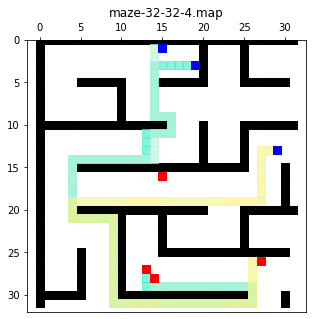

In [36]:
# Один тест MA-CBS

map_file = 'tests/maze-32-32-4.map'
scen_file = 'tests/tests-maze/maze-32-32-4-even-1.scen'

w, h, cells = read_map_from_movingai_file(map_file)
tasks = read_tasks_from_movingai_file(scen_file)

task_map = Map()
task_map.SetGridCells(w, h, cells)

num = 4

Starts = [(item[0], item[1]) for item in tasks[2:num+2]]
Goals = [(item[2], item[3]) for item in tasks[2:num+2]]

Border = 3
isMR = True

result = MACBS(task_map, Starts, Goals, Border, isMR)

if result[0]:
    print(f'Final cost {result[1].g},\nEuclidean cost {sum([tasks[i][-1] for i in range(num)])}')
    
    obs_x = []
    obs_y = []

    for y, cell_y in enumerate(task_map.cells):
        for x, cell_x in enumerate(cell_y):
            if cell_x == 1:
                obs_x.append(x)
                obs_y.append(y)
            
    x = np.array(obs_x)
    y = np.array(obs_y)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.set_ylim(task_map.height, 0)
    ax.xaxis.set_ticks_position('top')

    ax.scatter(x, y, c='black', marker='s', s=50)
    ax.set_facecolor('white')
    ax.set_title(map_file)

    color = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) + ''.join(['A', '0'])
             for i in range(num)]

    for ma in result[1].sol:
        for a in result[1].sol[ma]:
            path = result[1].sol[ma][a]
            x = []
            y = []
            for node in path:
                x.append(node.i)
                y.append(node.j)
            ax.scatter(x[1:-1], y[1:-1], c=color[a], marker='s', s=50)
            ax.scatter(x[:1], y[:1], c='blue', marker='s', s=50)
            ax.scatter(x[-1:], y[-1:], c='red', marker='s', s=50)

    plt.show()